In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

#importing keras and sub-libraries
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, MaxPool2D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def extract_plate(img): # the function detects and performs blurring on the number plate.
	plate_img = img.copy()
	
	#Loads the data required for detecting the license plates from cascade classifier.
	plate_cascade = cv2.CascadeClassifier('indian_license_plate.xml')

	# detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
	plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.3, minNeighbors = 7)
	print(img.shape)
	for (x,y,w,h) in plate_rect:
		a,b = (int(0.001*img.shape[0]), int(0.001*img.shape[1])) #parameter tuning
		plate = plate_img[y+a:y+h-a, x+b:x+w-b, :]
		# finally representing the detected contours by drawing rectangles around the edges.
		cv2.rectangle(plate_img, (x,y), (x+w, y+h), (51,51,255), 3)

	return plate_img, plate # returning the processed image

img = cv2.imread("car3.jpg")
plate_img, plate = extract_plate(img)
cv2.imshow('car', plate_img)
cv2.imshow('plate', plate)
cv2.waitKey(0)
cv2.destroyAllWindows()

(570, 870, 3)


In [3]:
import matplotlib.pyplot as plt

In [4]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        #detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        #checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            #extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

#             Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) #List that stores the character's binary image (unsorted)
            
    #Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    #arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [5]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255
    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

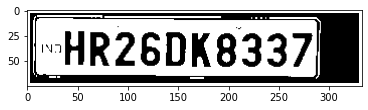

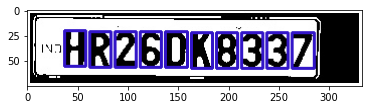

In [6]:
char = segment_characters(plate)

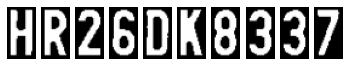

In [7]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

In [8]:
model = tf.keras.models.load_model('plate_char_recognition.h5')

In [9]:
def fix_dimension(img): 
  new_img = np.zeros((80,80,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (80,80))
        img = fix_dimension(img_)
        img = img.reshape(1,80,80,3) #preparing image for the model
        y = np.argmax(model.predict(img)[0], axis=-1)
        character = dic[y] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

HR26DK8337
